# LINMA2222 - Stochastic Optimal Control & Reinforcement Learning
## Portfolio optimal strategy
---

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Constants

In [3]:
THETA = 0.5
W_A = 0.1
W_U = 0.2
SIGMA_A = 0.018
SIGMA_P = 0.02
BETA_U = -0.048
GAMMA_U = 0.06

### Plot functions

In [54]:
def generate_trajectories(policy, x0=(0, 0, 0), T=1000):
    """Generate the state variables x_t and actions u_t for t=0,...,T
       using the given policy.

    Args:
        policy: a function that takes in the current state x_t and returns an action u_t
        x0 (ndarray): initial state. Defaults to 0.
        T (int): number of time steps. Defaults to 1000.
    """
    x = np.zeros((T+1, 3))
    u = np.zeros((T, 1))
    x[0] = x0

    for t in range(T):
        u[t] = policy(x[t])
        x[t+1, 0] = x[t, 0] + u[t] # q_t
        x[t+1, 1] = (1 - W_A) * x[t, 1] + W_A * SIGMA_A * np.random.normal(0, 1)  # za_t
        x[t+1, 2] = (1 - W_U) * x[t, 2] + W_U * BETA_U * u[t]  # zu_t

    return x, u

def g(x, u):
    """Compute the gross stage reward at each time given state x and action u."""
    q, za, zu = x[:, 0], x[:, 1], x[:, 2]
    xi_p = np.random.normal(0, 1, size=x.shape[0])

    # Formula found by replacing p_t+1 and p_t by their expressions in the given model (see Question 2.3)
    return q * (za + zu + (GAMMA_U * u) + (SIGMA_P * xi_p)) + THETA * u * (za + zu + (SIGMA_P * xi_p))


def c(g):
    """Compute the net stage reward given gross stage reward g_t for each time t"""
    return np.maximum(g - (np.pow(g, 2) / 2), 1 - np.exp(-g))

def average_reward(x, u, t):
    """Compute the average reward over the trajectory given states x and actions u from time 0 to t."""
    g_t = g(x[:t, :], u[:t])
    c_t = c(g_t)
    return np.mean(c_t)


def plot_trajectories(x, u, r, filename=None, mean=False, variance=False):
    """Plot the trajectories of the state variables and actions over time in a 2x2 grid
       and add an additional plot for the average reward as a function of time."""
    
    T = x.shape[0] - 1
    time = np.arange(T+1)

    fig, axs = plt.subplots(2, 2, figsize=(18, 10))

    axs[0, 0].plot(time, x[:, 0], label=r'$q_t$', color='blue')
    if mean:
        axs[0, 0].hlines(np.mean(x[:, 0]), 0, T, colors='darkblue', linestyles='dashed', label='Mean')
    if variance:
        axs[0, 0].fill_between(time, np.mean(x[:, 0]) - np.std(x[:, 0]), np.mean(x[:, 0]) + np.std(x[:, 0]), color='cyan', alpha=0.3, label='Variance')
    axs[0, 0].set_title(r'$q_t$')
    axs[0, 0].set_xlabel('Time')
    axs[0, 0].set_ylabel(r'$q_t$')
    axs[0, 0].grid()
    axs[0, 0].legend()

    axs[0, 1].plot(time, x[:, 1], label=r'$z^{a}_{t}$', color='orange')
    if mean:
        axs[0, 1].hlines(np.mean(x[:, 1]), 0, T, colors='darkorange', linestyles='dashed', label='Mean')
    if variance:
        axs[0, 1].fill_between(time, np.mean(x[:, 1]) - np.std(x[:, 1]), np.mean(x[:, 1]) + np.std(x[:, 1]), color='moccasin', alpha=1, label='Variance')
    axs[0, 1].set_title(r'$z^{a}_{t}$')
    axs[0, 1].set_xlabel('Time')
    axs[0, 1].set_ylabel(r'$z^{a}_{t}$')
    axs[0, 1].grid()
    axs[0, 1].legend()

    axs[1, 0].plot(time, x[:, 2], label=r'$z^{u}_{t}$', color='green')
    if mean:
        axs[1, 0].hlines(np.mean(x[:, 2]), 0, T, colors='darkgreen', linestyles='dashed', label='Mean')
    if variance:
        axs[1, 0].fill_between(time, np.mean(x[:, 2]) - np.std(x[:, 2]), np.mean(x[:, 2]) + np.std(x[:, 2]), color='lightgreen', alpha=1, label='Variance')
    axs[1, 0].set_title(r'$z^{u}_{t}$')
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel(r'$z^{u}_{t}$')
    axs[1, 0].grid()
    axs[1, 0].legend()

    axs[1, 1].plot(time[:-1], u, label=r'$u_{t}$', color='red')
    if mean:
        axs[1, 1].hlines(np.mean(u), 0, T-1, colors='darkred', linestyles='dashed', label='Mean')
    if variance:
        axs[1, 1].fill_between(time[:-1], np.mean(u) - np.std(u), np.mean(u) + np.std(u), color='lightcoral', alpha=1, label='Variance')
    axs[1, 1].set_title(r'$u_{t}$')
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel(r'$u_{t}$')
    axs[1, 1].grid()
    axs[1, 1].legend()

    plt.tight_layout()
    if filename:
        plt.savefig("figures/" + filename + "_states_actions.svg", format='svg')
    plt.show()

    # Plot average reward as a function of time
    avg_rewards = [average_reward(x, u, t) for t in range(1, T+1)]
    
    plt.figure(figsize=(9, 5))
    plt.plot(np.arange(1, T+1), avg_rewards, label='Average Reward', color='purple')
    plt.title('Average Reward Over Time')
    plt.xlabel('Time')
    plt.ylabel('Average Reward')
    plt.grid()

    plt.legend()
    if filename:
        plt.savefig("figures/" + filename + "_average_reward.svg", format='svg')
    plt.show()



### Question 3.1

$\pi_{cl}(x_t) = K_{cl} x_t$


/tmp/ipykernel_19809/699620422.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[t+1, 0] = x[t, 0] + u[t] # q_t
/tmp/ipykernel_19809/699620422.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[t+1, 2] = (1 - W_U) * x[t, 2] + W_U * BETA_U * u[t]  # zu_t


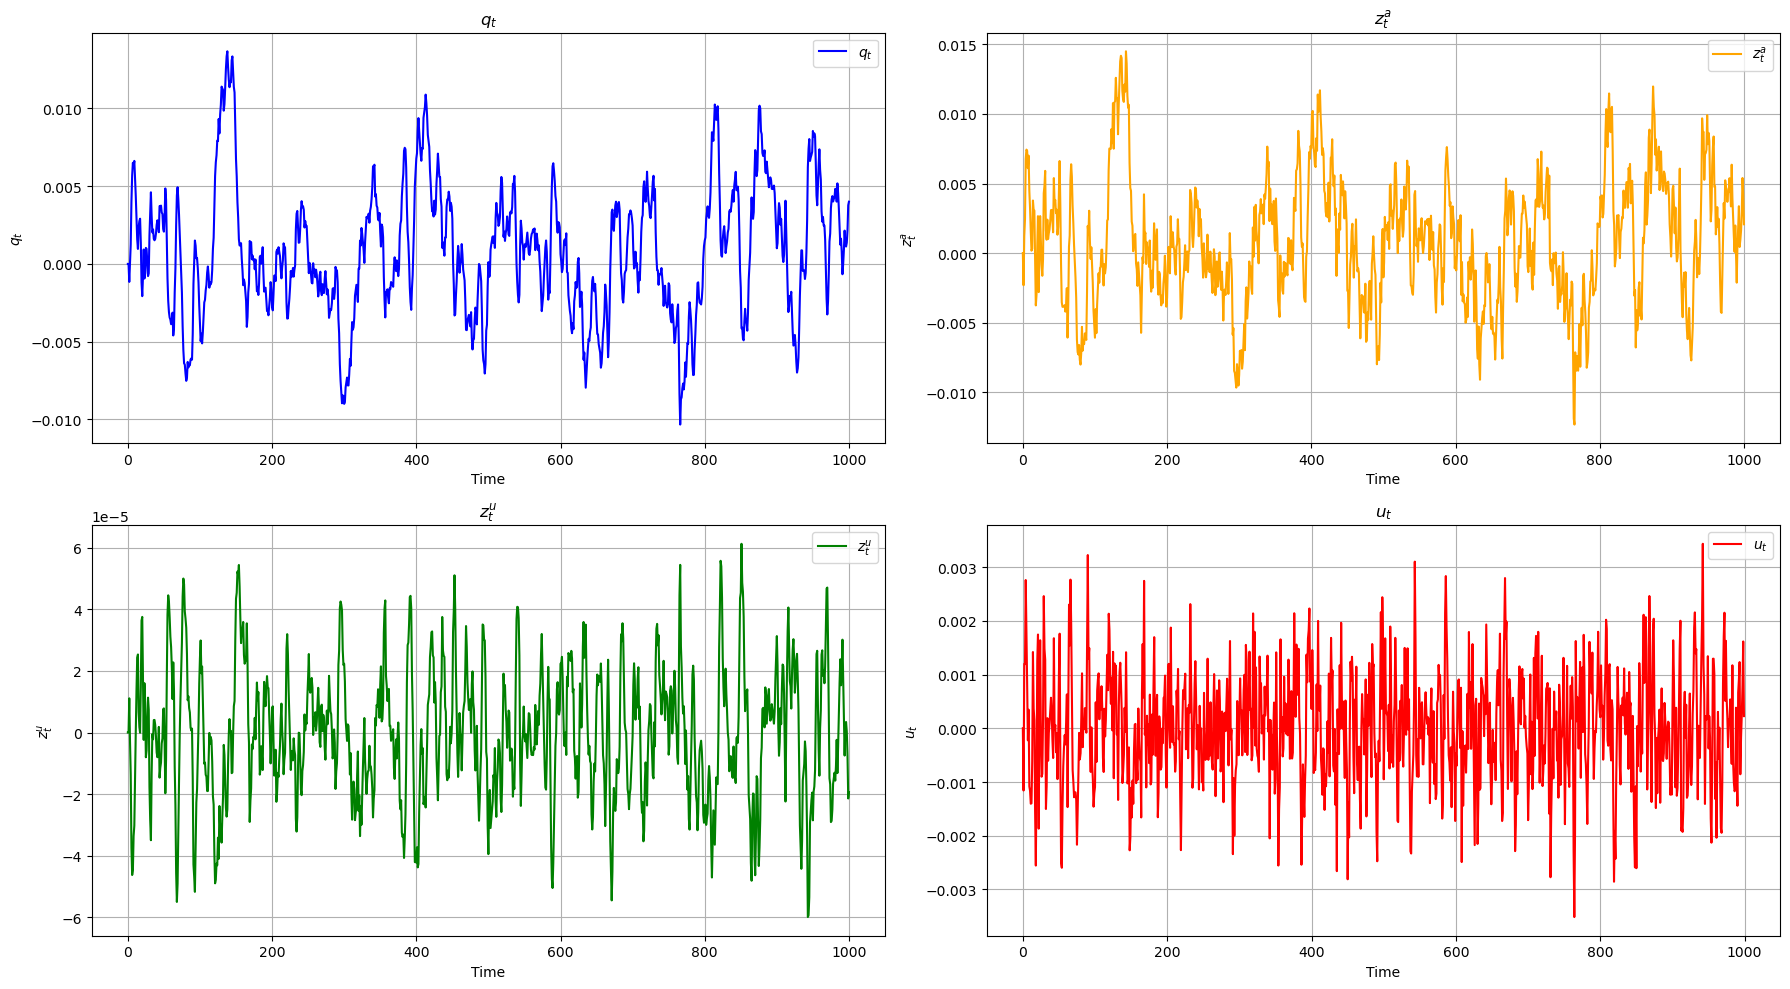

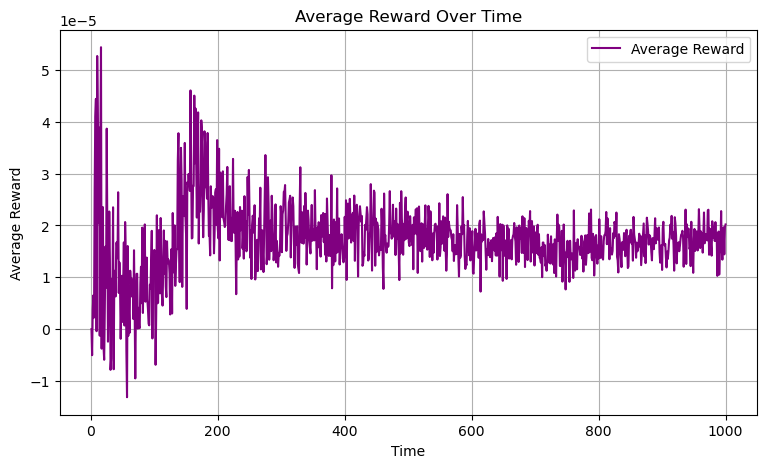

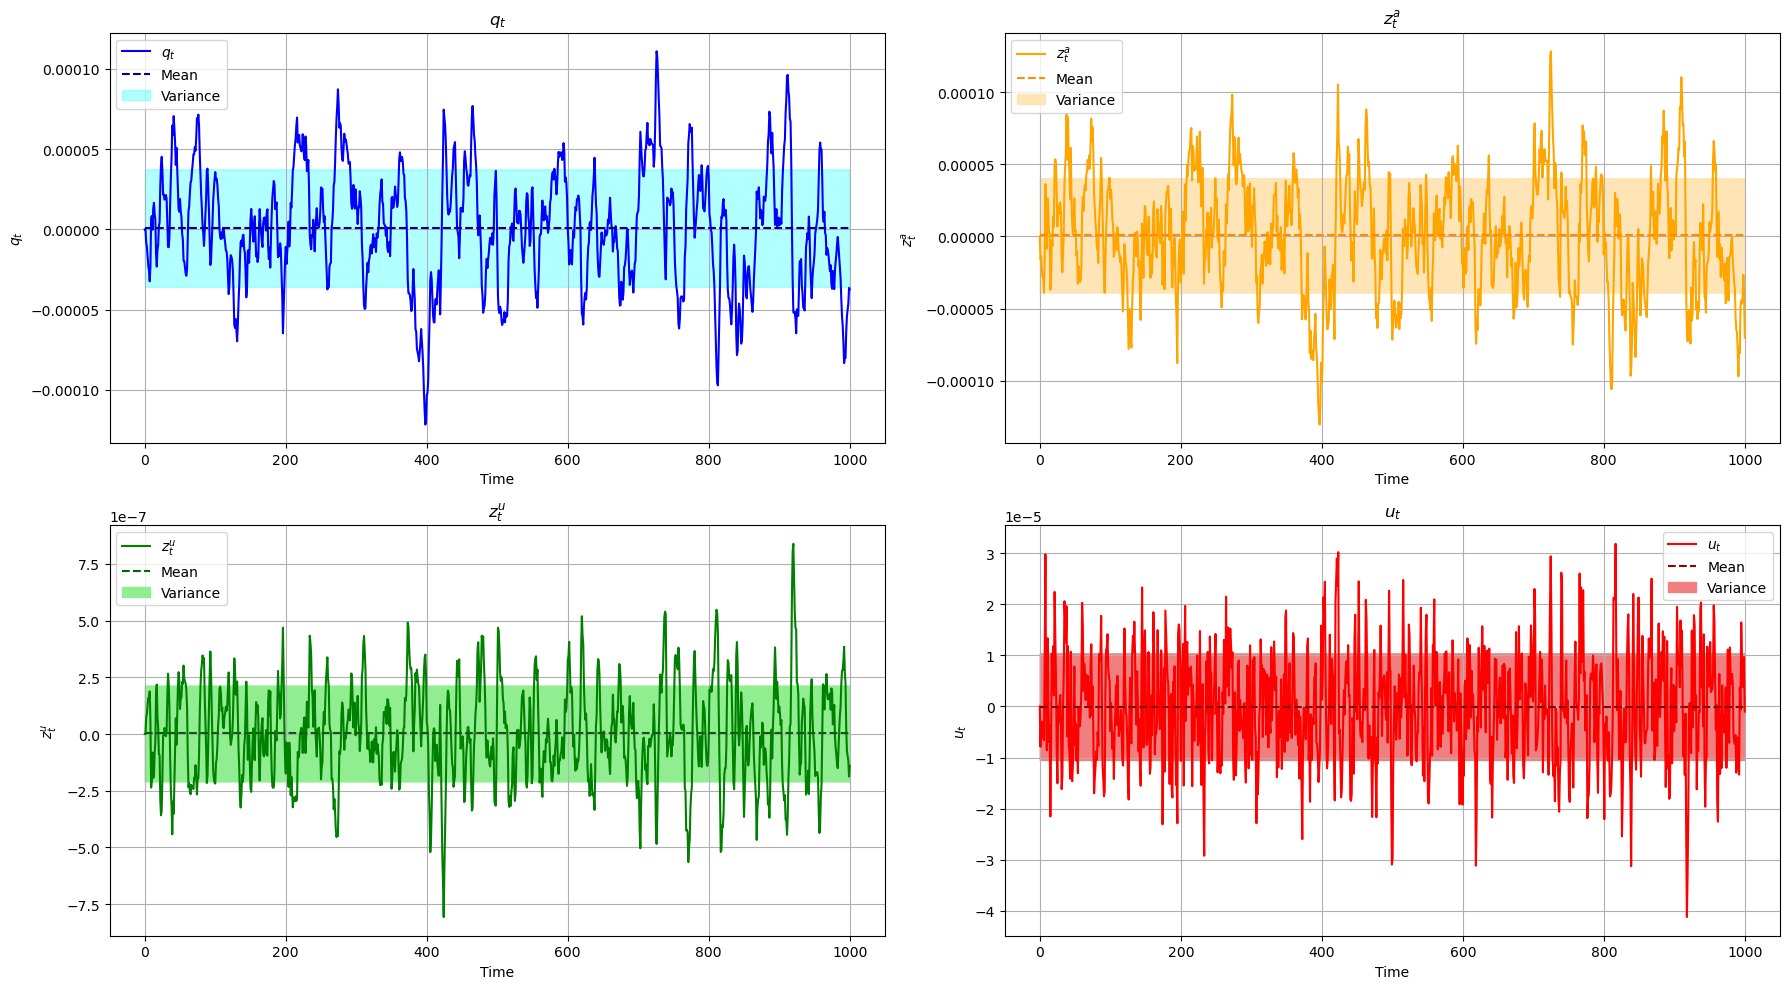

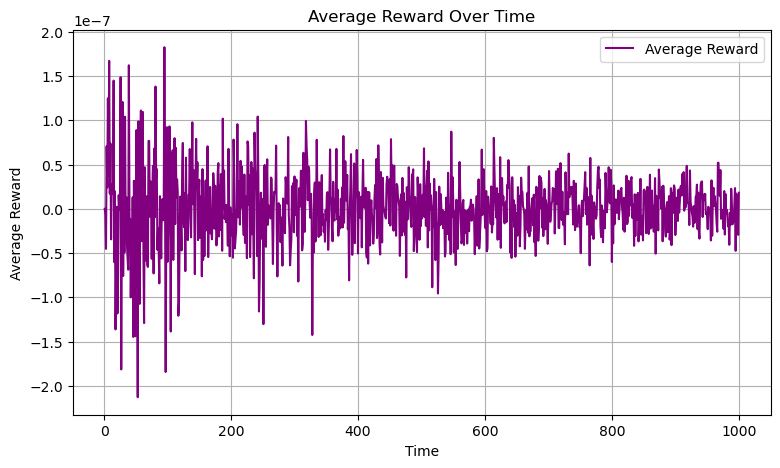

In [70]:
# Question 3.1.1
policy = lambda x: -0.5 * x[0] + 0.5 * x[1] + 0.5 * x[2]
x, u = generate_trajectories(policy, x0=(0, 0, 0), T=1000)
r = average_reward(x, u, 1000)

plot_trajectories(x, u, r, filename="question_3_1_1")

# Question 3.1.2
N = 10000
all_x = []
all_u = []
for i in range(N):
    x, u = generate_trajectories(policy, x0=(0, 0, 0), T=1000)
    all_x.append(x)
    all_u.append(u)

#r = np.mean([average_reward(x, u, 1000) for x, u in zip(all_x, all_u)])

x = np.mean(np.array(all_x), axis=0)
u = np.mean(np.array(all_u), axis=0)
r = average_reward(x, u, 1000)

plot_trajectories(x, u, r, filename="question_3_1_2", mean=True, variance=True)
